In [123]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [124]:
A = np.random.normal(size=[100,2])
B = np.random.normal(size=[200,2], loc=1)
data = np.concatenate([A,B])

yA1 = np.array([1]*100 + [0]*200)
yA2 = np.array([0]*100 + [1]*200)
yB = np.ones(300)
y = np.concatenate([yA1[:,np.newaxis], yA2[:,np.newaxis], yB[:,np.newaxis]], axis=1)

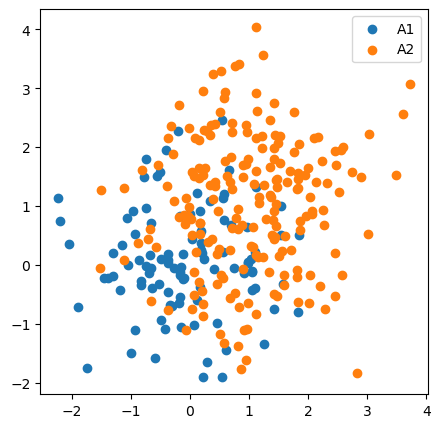

In [125]:
plt.figure(figsize=(5,5))
plt.scatter(data[y[:,0]==1,0],data[y[:,0]==1,1], label='A1')
plt.scatter(data[y[:,1]==1,0],data[y[:,1]==1,1], label='A2')
plt.legend()
plt.show()

In [126]:
def get_area(x1, y1, x2, y2):
    '''
    x1 < x2, the inequality should be strict
    '''
    return (y1 + y2) * (x2 - x1) / 2

def get_score(model, x, y):
    local_logits, global_logits = model(x)
    local_logits, global_logits = model.postprocess(local_logits, global_logits)
    total_prob, local_prob, global_prob = model.get_prob(local_logits, global_logits)
    
    precision_list = [0]
    recall_list = [1]
    for threshold in np.arange(0.01, 1, 0.01):
        pred_int = tf.cast(total_prob >= threshold, tf.int16)
        tp = pred_int * y 
        fp = pred_int * (1-y)
        fn = (1-pred_int) * y
        
        tp = tf.reduce_sum(tp)
        fp = tf.reduce_sum(fp)
        fn = tf.reduce_sum(fn)
        
        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        
        if not (np.isnan(precision) or np.isnan(recall)):
            precision_list.append(precision)
            recall_list.append(recall)
        
    idx = np.argsort(precision_list)
    precision_np = np.array(precision_list)
    recall_np = np.array(recall_list)
    
    precision_np = precision_np[idx]
    recall_np = recall_np[idx]
    
    area = 0 
    for i in range(len(precision_np)-1):
        area += get_area(precision_np[i], recall_np[i], precision_np[i+1], recall_np[i+1])
    
    return area

In [127]:
def get_max_with_structure(structure):
    ''' 
    structure   an np.array with shape [M,M], where M is the number of all classes
                structure[i,j] == 1 iff "i" is a subclass of "j". Remind that "i" is 
                subclass of itself, so the diagonal elements are all 1
    '''
    def max_with_structure(logits):
        '''
        logits      outputs of a neural net before sigmoid activation, shape = [N,M]
        '''
        logits = logits[..., tf.newaxis] # [N,M,1]
        
        structure1 = structure + np.eye(structure.shape[0])
        structure1 = np.where(structure1 == 0, -np.inf, structure1)
        structure1 = np.where(structure1 == 1, 0, structure1)
        structure1 = tf.convert_to_tensor(structure1[np.newaxis,...], tf.float32) # [1,M,M]
        
        logits = logits + structure1 # [N,M,M]
        logits = tf.reduce_max(logits, axis=1) #[N,M]
        
        logits = tf.where(tf.math.is_inf(logits), np.inf, logits)
        return logits 
    return max_with_structure

In [128]:
class CoherentLSTM(tf.keras.Model):
    def __init__(self, units, beta, num_classes_list, num_layers, structure):
        super(CoherentLSTM, self).__init__()
        self.units = units
        self.beta = beta 
        self.num_layers = num_layers
        self.structure = structure 
        
        self.input_gate = Dense(units, activation='sigmoid')
        self.forget_gate = Dense(units, activation='sigmoid')
        self.output_gate = Dense(units, activation='sigmoid')
        self.candidate_gate = Dense(units, activation='tanh')
        
        self.local_W = list()
        for i in range(num_layers):
            self.local_W.append(Dense(num_classes_list[i]))
        self.global_W = Dense(tf.reduce_sum(num_classes_list))
        
    def call(self, inputs):
        # init 
        x = tf.concat(
            [inputs, tf.zeros([inputs.shape[0], self.units])],
            axis = -1
        )
        candidate_last = tf.zeros(self.units)
        local_logits = list()
        
        # main loop
        for i in range(self.num_layers):
            # gates
            forget_prob = self.forget_gate(x)
            input_prob = self.input_gate(x)
            output_prob = self.output_gate(x)
            candidate_hat = self.candidate_gate(x)
            
            # outputs
            candidate = input_prob * candidate_hat + forget_prob * candidate_last
            outputs = output_prob * tf.math.tanh(candidate)
            
            # update
            candidate_last = candidate 
            x = tf.concat([inputs, outputs], axis=-1)
            
            local_logits.append(self.local_W[i](outputs))
            
        global_logits = self.global_W(
            tf.concat([inputs, outputs], axis=-1)
        )
        
        return tf.concat(local_logits, axis=-1), global_logits
    
    def postprocess(self, local_logits, global_logits):
        max_with_structure = get_max_with_structure(self.structure)
        local_logits = max_with_structure(local_logits)
        global_logits = max_with_structure(global_logits)
        return local_logits, global_logits
    
    def get_prob(self, local_logits, global_logits):
        local_prob = tf.math.sigmoid(local_logits)
        global_prob = tf.math.sigmoid(global_logits)
        total_prob = self.beta * local_prob + (1-self.beta) * global_prob
        return total_prob, local_prob, global_prob

In [129]:

def loss_fn_traditional(y_true, y_pred):
    ''' 
    y_pred should contain post processed local and global logits
    '''
    local_logits, global_logits = y_pred 
    local_loss = tf.nn.sigmoid_cross_entropy_with_logits(y_true, local_logits)
    global_loss = tf.nn.sigmoid_cross_entropy_with_logits(y_true, global_logits)
    return tf.reduce_mean(local_loss) + tf.reduce_mean(global_loss) 

In [130]:
def get_train_fn(model, loss_fn, optimizer):
    def train_fn(x, y):
        with tf.GradientTape() as tape:
            local_logits, global_logits = model(x)
            local_logits, global_logits = model.postprocess(local_logits, global_logits)
            loss = loss_fn(y, [local_logits, global_logits])
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
        return loss 
    return train_fn

In [131]:
structure = np.array([[0,0,1],[0,0,1],[0,0,0]])
model = CoherentLSTM(10, 0.5, [2,1], 2, structure)
train_fn = get_train_fn(model, loss_fn_traditional, tf.keras.optimizers.Adam(1e-2))

In [132]:
for epoch in range(100):
    loss = train_fn(data, tf.convert_to_tensor(y, tf.float32))
    if (epoch+1) % 10 == 0:
        print("epoch {}/100, loss {}".format(epoch+1, loss))

epoch 10/100, loss 1.1338696479797363
epoch 20/100, loss 0.9518829584121704
epoch 30/100, loss 0.8266856074333191
epoch 40/100, loss 0.7484595775604248
epoch 50/100, loss 0.6956615447998047
epoch 60/100, loss 0.6536952257156372
epoch 70/100, loss 0.6238783001899719
epoch 80/100, loss 0.6110279560089111
epoch 90/100, loss 0.6044628024101257
epoch 100/100, loss 0.601354718208313


In [133]:
local_logits, global_logits = model(data)
local_logits, global_logits = model.postprocess(local_logits, global_logits)
total_prob, local_prob, global_prob = model.get_prob(local_logits, global_logits)
print('AU(PRC)={}'.format(get_score(model, data, y)))

AU(PRC)=0.9692735421624654


The original loss function is written as $L_A = -y_A \log(\max_B\{y_B h_B\}) - (1-y_A) \log (\max_B\{h_B\})$, where $h_B=sigmoid(x_B)$. To avoid underflow in log function, we insert the sigmoid function into $L_A$ and write 

$$
L_A = -y_A \log\left(\max_B \left[\frac{y_B}{1+\exp(-x_B)} \right]\right) - (1-y_A) \log\left(1-\max_B\left[\frac{1}{1+\exp(-x_B)}\right]\right) 
$$

Construct 

$$
\tilde{y}_B =
\begin{cases}
 1, &\text{if $y_B = 1$} \\
              -\infty \times sign(x_B) , &\text{if $y_B = 0$} 
\end{cases}
$$

We can see that 
$$
L_A = y_A \log \left(1 + \exp(-\max_B \{\tilde{y}_B x_B\}) \right) + (1-y_A) \log \left(1+\exp(-\max_B \{x_B\})\right) + (1-y_A)  \max \{x_B\}
$$

Furthermore, to avoid overflow in the exponential function when $x<0$, write
$$
\begin{aligned}
\log\left(1+\exp(-x)\right) &= -x + x + \log\left(1+\exp(-x)\right) \\
&= -x + \log\left(\exp(x)\right) + \log\left(1+\exp(-x)\right) \\
&= -x + \log\left(1+\exp(x)\right)
\end{aligned}
$$

Generally, we have
$$
\log\left(1+\exp(-x)\right) = \max\{-x, 0\} + \log\left(1+\exp(-|x|)\right)
$$

In [134]:
def softplus(x):
    ''' 
    return log(1+exp(-x))
    '''
    r = tf.maximum(-x, 0) + tf.math.log(1 + tf.exp(-tf.abs(x)))
    return r 

def get_cross_logits_y(y):
    @tf.custom_gradient
    def cross_logits_y(logits):
        outputs = tf.where(y == 0, -np.inf, logits)
        def grad(upstream):
            return upstream * tf.where(y == 1, 1.0, 0.0)
        return outputs, grad
    return cross_logits_y

def get_loss_fn_logits(model):
    def loss_fn_logits(y_true, y_pred):
        ''' 
        y_pred      logits before postprocessing
        '''
        local_logits, global_logits = y_pred
        cross_logits_y = get_cross_logits_y(y_true)
        max_with_structure = get_max_with_structure(model.structure)
        
        loss1 = y_true * softplus(max_with_structure(cross_logits_y(local_logits)))
        loss2 = (1-y_true) * softplus(max_with_structure(local_logits)) 
        loss3 = (1-y_true) * max_with_structure(local_logits)
        local_loss = tf.reduce_mean(loss1 + loss2 + loss3)
        
        loss1 = y_true * softplus(max_with_structure(cross_logits_y(global_logits)))
        loss2 = (1-y_true) * softplus(max_with_structure(global_logits)) 
        loss3 = (1-y_true) * max_with_structure(global_logits)
        global_loss = tf.reduce_mean(loss1 + loss2 + loss3)
        
        return local_loss + global_loss
    return loss_fn_logits

In [135]:
structure = np.array([[0,0,1],[0,0,1],[0,0,0]])
model = CoherentLSTM(10, 0.5, [2,1], 2, structure)
loss_fn = get_loss_fn_logits(model)
train_fn = get_train_fn(model, loss_fn, tf.keras.optimizers.Adam(1e-2))

for epoch in range(100):
    loss = train_fn(data, tf.convert_to_tensor(y, tf.float32))
    if (epoch+1) % 10 == 0:
        print("epoch {}/100, loss {}".format(epoch+1, loss))

epoch 10/100, loss 1.0192092657089233
epoch 20/100, loss 0.8898001909255981
epoch 30/100, loss 0.8147627115249634
epoch 40/100, loss 0.7656739950180054
epoch 50/100, loss 0.7251306772232056
epoch 60/100, loss 0.6874844431877136
epoch 70/100, loss 0.6561836004257202
epoch 80/100, loss 0.6319832801818848
epoch 90/100, loss 0.6162023544311523
epoch 100/100, loss 0.6066035032272339


In [136]:
local_logits, global_logits = model(data)
local_logits, global_logits = model.postprocess(local_logits, global_logits)
total_prob, local_prob, global_prob = model.get_prob(local_logits, global_logits)
print('AU(PRC)={}'.format(get_score(model, data, y)))

AU(PRC)=0.9693861622075257


Comparison between square loss and cross entropy loss for binary classification. Let 
$$
L_1 = (y-p(\hat{y}))^2 
$$
and 
$$
L_2 = -y\cdot\log(p(\hat{y})) - (1-y) \cdot (\log(1-p(\hat{y})))
$$
where 
$$
p(\hat{y}) = \frac{1}{1+e^{-\hat{y}}}
$$
Now, let's see the gradients of the above 2 losses with respect to $\hat{y}$. 
$$
\frac{d L_1}{d\hat{y}} = \frac{d L_1}{d p} \cdot \frac{d p}{d\hat{y}} = 2(p-y)\cdot p (1-p)
$$
and 
$$
\frac{d L_2}{d\hat{y}} = \frac{d L_2}{d p} \cdot \frac{d p}{d\hat{y}} = - \frac{y}{p} \cdot p(1-p) + \frac{1-y}{1-p} \cdot p(1-p) = -y(1-p) + p(1-y) = p-y 
$$